<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [27]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [28]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [30]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [31]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [32]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [33]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x24034ff5e10>,
 ['pizza', 'steak', 'sushi'])

In [34]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

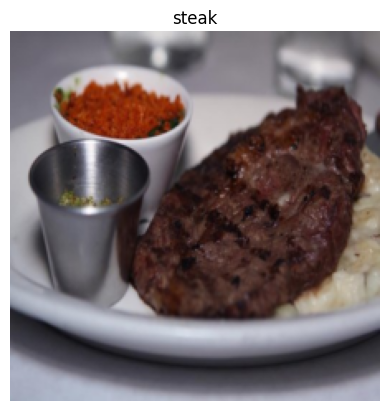

In [35]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [10]:
# TODO: your code
# Let's first create and train the models from the.
# I will use the helper function from chapter 9.

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms


Let's create EfficientNetB2 model, and train and evaluate the it.

In [ ]:
effnet_b2, effnet_b2_transforms = create_effnetb2_model()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnet_b2.parameters(), lr=0.001)

effnet_b2_results = engine.train(effnet_b2, train_dataloader, test_dataloader, optimizer, loss_fn, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0956 | train_acc: 0.3672 | test_loss: 0.9532 | test_acc: 0.7206
Epoch: 2 | train_loss: 0.9017 | train_acc: 0.6367 | test_loss: 0.8716 | test_acc: 0.7528
Epoch: 3 | train_loss: 0.8312 | train_acc: 0.7266 | test_loss: 0.7490 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.6947 | train_acc: 0.8945 | test_loss: 0.7135 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.7076 | train_acc: 0.7500 | test_loss: 0.6991 | test_acc: 0.8362
Epoch: 6 | train_loss: 0.6034 | train_acc: 0.9141 | test_loss: 0.6192 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.5993 | train_acc: 0.8125 | test_loss: 0.6248 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5092 | train_acc: 0.9375 | test_loss: 0.6128 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5207 | train_acc: 0.8008 | test_loss: 0.6038 | test_acc: 0.8163
Epoch: 10 | train_loss: 0.5219 | train_acc: 0.8125 | test_loss: 0.5705 | test_acc: 0.9280


Now, let's do the same with ViT model.

In [ ]:
vit, vit_transforms = create_vit_model()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

vit_results = engine.train(vit, train_dataloader, test_dataloader, optimizer, loss_fn, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8128 | train_acc: 0.6797 | test_loss: 0.6076 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.4858 | train_acc: 0.9141 | test_loss: 0.3889 | test_acc: 0.9384
Epoch: 3 | train_loss: 0.3034 | train_acc: 0.9375 | test_loss: 0.2978 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.2351 | train_acc: 0.9375 | test_loss: 0.2658 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.2055 | train_acc: 0.9453 | test_loss: 0.2355 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.1754 | train_acc: 0.9570 | test_loss: 0.2142 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.3541 | train_acc: 0.8438 | test_loss: 0.2175 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.1602 | train_acc: 0.9531 | test_loss: 0.2679 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1586 | train_acc: 0.9531 | test_loss: 0.2213 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.1334 | train_acc: 0.9727 | test_loss: 0.1838 | test_acc: 0.9688


Let's compare the prediction time on the GTX 940MX GPU (Yeah, this is the GPU on my laptop. For some reason Colab is not cooperating with me to use its GPU.)

First, we will copy the helper function from chapter 9 to make prediction on test set and save some stats. We need test data path to do so. So, let's copy that code as well.

In [ ]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data\pizza_steak_sushi\test


[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg')]

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

We have our helper function ready. Let's use this function to make predictions on both, EfficietNetB2 and ViT models and compare the prediction time on CUDA device.

In [ ]:
# Make predictions on effnet_b2 and save stats.
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnet_b2,
                                          transform=manual_transforms,
                                          class_names=class_names,
                                          device=device)

# Make predictions on vit and save stats.
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=manual_transforms,
                                     class_names=class_names,
                                     device=device)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
# Turn effnetb2_test_pred_dicts into a DataFrame
import pandas as pd
effnet_b2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnet_b2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi\test\pizza\1152100.jpg,pizza,0.6177,pizza,0.1623,True
1,data\pizza_steak_sushi\test\pizza\1503858.jpg,pizza,0.6473,pizza,0.0483,True
2,data\pizza_steak_sushi\test\pizza\1687143.jpg,pizza,0.8370,pizza,0.0667,True
3,data\pizza_steak_sushi\test\pizza\1925494.jpg,pizza,0.7843,pizza,0.0404,True
4,data\pizza_steak_sushi\test\pizza\194643.jpg,pizza,0.6593,pizza,0.0393,True


In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi\test\pizza\1152100.jpg,pizza,0.9837,pizza,0.1182,True
1,data\pizza_steak_sushi\test\pizza\1503858.jpg,pizza,0.9893,pizza,0.1214,True
2,data\pizza_steak_sushi\test\pizza\1687143.jpg,pizza,0.9968,pizza,0.1148,True
3,data\pizza_steak_sushi\test\pizza\1925494.jpg,pizza,0.9967,pizza,0.1168,True
4,data\pizza_steak_sushi\test\pizza\194643.jpg,pizza,0.9901,pizza,0.1172,True


First, we will calculate the average time for predictions for both of the models and then we will compare the average time.

In [ ]:
# Average prediction time for Efficient Net B2
effnet_b2_avg_pred_time = round(effnet_b2_test_pred_df.time_for_pred.mean(), 4)

# Average prediction time for ViT
vit_avg_pred_time = round(vit_test_pred_df.time_for_pred.mean(), 4)

In [ ]:
effnet_b2_avg_pred_time, vit_avg_pred_time

(0.0433, 0.1158)

Hmm, it turns out that even on CUDA device, the average time for Efficient Net B2 is less than the ViT.

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [11]:
# Create a ViT model for Food101
vit_food101, vit_food101_transforms = create_vit_model(num_classes=101)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # Label smoothing is a regularization technique when we have a large number of classes
optimizer = torch.optim.Adam(params=vit_food101.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 72.1MB/s]


In [12]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_food101_transforms,
])

In [13]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_food101_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

100%|██████████| 4996278331/4996278331 [13:27<00:00, 6190817.81it/s]


Extracting data/food-101.tar.gz to data


In [14]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [16]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [43]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [18]:
# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
vit_food101_results = engine.train(model=vit_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.0665 | test_acc: 0.6257
Epoch: 2 | train_loss: 2.2209 | train_acc: 0.5931 | test_loss: 1.9249 | test_acc: 0.6657
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 1.8675 | test_acc: 0.6981
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6810 | test_loss: 1.8514 | test_acc: 0.6989
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7009 | test_loss: 1.8297 | test_acc: 0.7078


## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [69]:
# TODO: your code
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image

def pred_and_plot_misclassified_samples(model, test_dir, test_dataloader, class_names, device):

  test_preds = []
  test_preds_probs = []
  test_true = []
  wrong_preds = []

  model.eval()
  with torch.inference_mode():
      for X, y in tqdm(test_dataloader):
          X, y = X.to(device), y.to(device)
          preds_logits = model(X)
          preds_probs = preds_logits.softmax(dim=1)
          preds_labels = preds_probs.argmax(dim=1)

          test_preds_probs.append(preds_probs.cpu())
          test_preds.append(preds_labels.cpu())
          test_true.append(y.cpu())

  test_preds = torch.cat(test_preds)
  test_true = torch.cat(test_true)
  test_preds_probs = torch.cat(test_preds_probs)

  # Get the tensor with values which don't match (Misclassification)
  wrong_preds = torch.ne(test_preds, test_true)

  # Get the indices of the misclassified examples
  wrong_preds_indices = wrong_preds.nonzero().squeeze()

  # Get the class labels by using masking technique
  wrong_preds_labels = [class_names[label] for label in test_preds[wrong_preds_indices]]
  true_labels = [class_names[label] for label in test_true[wrong_preds_indices]]

  # Get the probabiities of the misclassified examples
  wrong_probs = [round(test_preds_probs[idx].max().item(), 3) for idx in wrong_preds_indices]
  test_data_paths = test_dir
  misclassified_data = [test_data_paths[idx] for idx in wrong_preds_indices]
  df = {
    "samples": misclassified_data,
    "true_labels": true_labels,
    "predicted_labels": wrong_preds_labels,
    "probabilities": wrong_probs
  }
  df = pd.DataFrame(df)
  top_5_misclassified_samples = df.sort_values(by=["probabilities"], ascending=False).head(5)

  plt.figure(figsize=(16, 8))
  rows = 5
  cols = 1

  for i, (index, row) in enumerate(top_5_misclassified_samples.iterrows(), start=1):
      image = Image.open(row['samples'])
      true_label = row['true_labels']
      predicted_label = row['predicted_labels']
      prob = row['probabilities']

      plt.subplot(rows, cols, i)
      plt.imshow(image)
      plt.title(f"True: {true_label} | Predicted: {predicted_label} | Prob: {prob}")
      plt.axis(False)

In [72]:
with open("data/food-101/meta/test.txt", "r") as f:
    lines = f.readlines()
    root_dir = "data/food-101/images/"
    new_lines = [(root_dir + line.strip('\n') + ".jpg") for line in lines]

  0%|          | 0/158 [00:00<?, ?it/s]

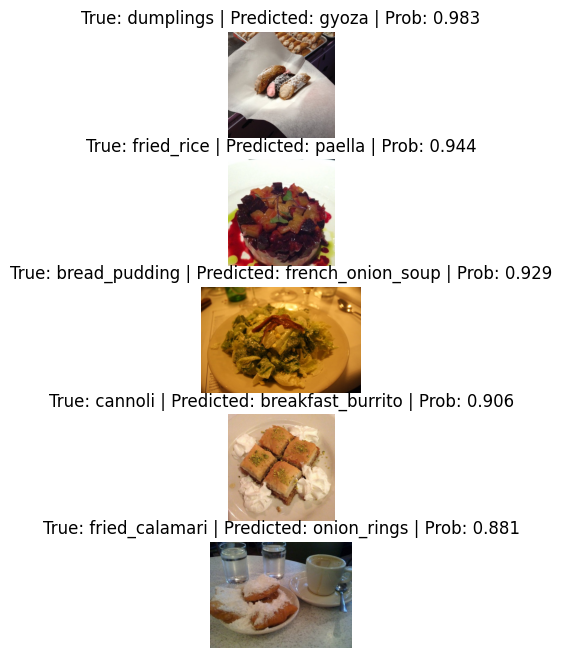

In [73]:
pred_and_plot_misclassified_samples(vit_food101, new_lines, test_dataloader_food101_20_percent, food101_class_names, device)

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [11]:
# TODO: your code
# Can't do it. Ran out of credits on Google Colab. Maybe later.

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

# TODO: your answer to the above

The leaderboard shows that a model named Swin achieved the accuracy of 92%.

[Link to Hugging Face repo](https://huggingface.co/Neruoy/swin-finetuned-food101-e3)

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

# TODO: your answer to the above

**1. Someone upload a photo of non-food item:** We can create two models to solve this problem. One model will classify the item as food or not. If it classifies an item as a food, then then second model will try to predict which food is that. Otherwise, if the first model classifies the item as a non-food, then print some kind of message to user to let them know.

**2. Misclassification:** It is not guaranteed that the deployed model will always provide accurate predictions. We can utilize some kind of feedback feature where the user will be able to provide feedback if the model is providing correct predictions or not. This is an essential aspect of monitoring the deployed models.

**3. Changing data with time:** It is not uncommon that the data used to make predictions in production changes eventually. That can lead to incorrect predictions due to the change in underlying structure data that the model was trained on. To mitigate this issue, there is a need to monitor the real-world dataset and the model performance on it and take appropriate actions to make sure our model keeps on predicting as accrately as possible in this world of inevitable change.

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

### Load a pre-trained model and its transforms to apply on dataset.

In [70]:
def create_mobile_net_v3l_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    
    weights = torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V2 # Default weights
    transforms = weights.transforms()
    model= torchvision.models.mobilenet_v3_large(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change last dense layer with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier[3] = nn.Linear(in_features=1280, out_features=num_classes)    

    return model, transforms

### Download and prepare dataset.

In [73]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_val_data = datasets.OxfordIIITPet(
    root="data",
    split="trainval",
    download=True,
    transform=mobile_net_v3l_transforms
)

test_data = datasets.OxfordIIITPet(
    root="data",
    split="test",
    download=True,
    transform=mobile_net_v3l_transforms
)

train_val_dataloader = DataLoader(train_val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
class_names = train_val_data.classes

In [75]:
len(train_val_data), len(test_data), len(class_names)

(3680, 3669, 37)

Let's visualize some of the images.

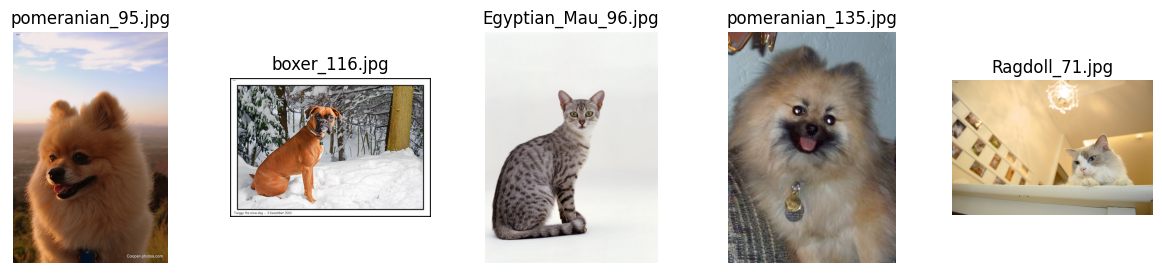

In [76]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to your image directory
image_directory = 'data/oxford-iiit-pet/images'

# Number of images you want to visualize
num_images_to_visualize = 5

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_directory) if f.endswith('.jpg')]

# Randomly select the specified number of images
selected_images = random.sample(image_files, num_images_to_visualize)

# Plot the selected images
fig, axes = plt.subplots(1, num_images_to_visualize, figsize=(15, 3))

for i, image_file in enumerate(selected_images):
    img_path = os.path.join(image_directory, image_file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(image_file)
    axes[i].axis('off')

plt.show()

### Load the model, define loss function and optimizer, and start training.

In [80]:
# Load the model
mobile_net_v3l, mobile_net_v3l_transforms = create_mobile_net_v3l_model(num_classes=len(class_names))

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mobile_net_v3l.parameters(), lr=0.001)

# Start training
mobile_net_v3l_results = engine.train(
    mobile_net_v3l,
    train_val_dataloader,
    test_dataloader,
    optimizer,
    loss_fn,
    10,
    device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8914 | train_acc: 0.6927 | test_loss: 0.8327 | test_acc: 0.8641
Epoch: 2 | train_loss: 0.6830 | train_acc: 0.8818 | test_loss: 0.5712 | test_acc: 0.8749
Epoch: 3 | train_loss: 0.4588 | train_acc: 0.9133 | test_loss: 0.5217 | test_acc: 0.8692
Epoch: 4 | train_loss: 0.3497 | train_acc: 0.9342 | test_loss: 0.4970 | test_acc: 0.8645
Epoch: 5 | train_loss: 0.2871 | train_acc: 0.9470 | test_loss: 0.4763 | test_acc: 0.8660
Epoch: 6 | train_loss: 0.2380 | train_acc: 0.9557 | test_loss: 0.4661 | test_acc: 0.8626
Epoch: 7 | train_loss: 0.1993 | train_acc: 0.9641 | test_loss: 0.4587 | test_acc: 0.8623
Epoch: 8 | train_loss: 0.1747 | train_acc: 0.9745 | test_loss: 0.4575 | test_acc: 0.8590
Epoch: 9 | train_loss: 0.1503 | train_acc: 0.9788 | test_loss: 0.4528 | test_acc: 0.8606
Epoch: 10 | train_loss: 0.1425 | train_acc: 0.9783 | test_loss: 0.4453 | test_acc: 0.8621


Woah! The model is over-fitting with a very high train accuracy! Let's plot the loss curves.

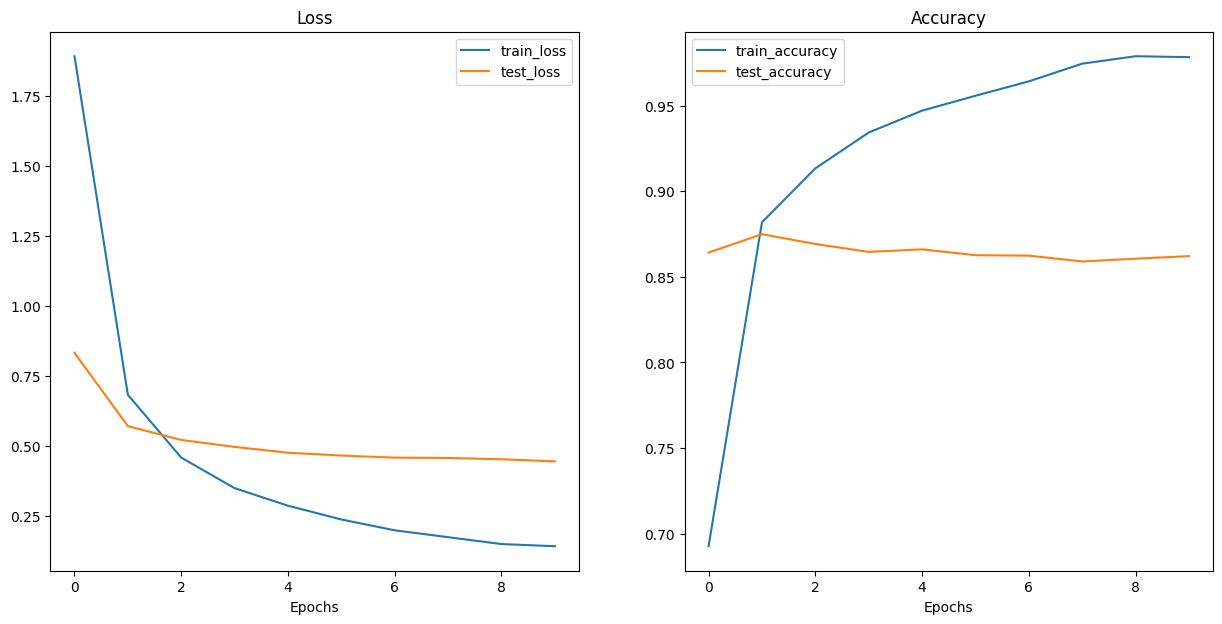

In [83]:
plot_loss_curves(mobile_net_v3l_results)

This is not good at all. We need to use some regularization techniques to make our model more general. But I am going to leave it for later becuase it takes a lot of time to train the model.

In [125]:
from going_modular.going_modular import utils

utils.save_model(model=mobile_net_v3l,
                 target_dir="models",
                 model_name="mobile_net_v3l_petvision_model.pth")

[INFO] Saving model to: models\mobile_net_v3l_petvision_model.pth


### Creating a demo Gradio App.

In [81]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

Gradio version: 4.21.0


As we learned in the chapter, it is important to consider what our app will do and where will we have to deploy the model. Since I am using MobileNet for this app, I will have to move the model to CPU for fast inference.

In [82]:
# Put EffNetB2 on CPU
mobile_net_v3l.to("cpu") 

# Check the device
next(iter(mobile_net_v3l.parameters())).device

device(type='cpu')

Recall Gradio workflow: Input -> Function -> Output

In [85]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = mobile_net_v3l_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    mobile_net_v3l.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(mobile_net_v3l(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [95]:
import random
from pathlib import Path
from PIL import Image
from timeit import default_timer as timer

test_dir_oxford_iiit_pet = "data/oxford-iiit-pet/images"

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir_oxford_iiit_pet).glob("*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data\oxford-iiit-pet\images\chihuahua_113.jpg

Prediction label and probability dictionary: 
{'Abyssinian': 0.0006638688500970602, 'American Bulldog': 1.0712200491980184e-05, 'American Pit Bull Terrier': 0.0007974491454660892, 'Basset Hound': 4.101044396520592e-05, 'Beagle': 1.4644132534158416e-05, 'Bengal': 0.0012379748513922095, 'Birman': 0.0001430898846592754, 'Bombay': 0.02054765447974205, 'Boxer': 7.21768374205567e-05, 'British Shorthair': 8.324668669956736e-06, 'Chihuahua': 0.8701432943344116, 'Egyptian Mau': 0.0001672887010499835, 'English Cocker Spaniel': 3.909084989572875e-05, 'English Setter': 4.096709380974062e-05, 'German Shorthaired': 0.0002004665439017117, 'Great Pyrenees': 7.851464033592492e-06, 'Havanese': 5.437598883872852e-05, 'Japanese Chin': 1.930109465320129e-05, 'Keeshond': 9.459688953938894e-06, 'Leonberger': 8.15144903754117e-06, 'Maine Coon': 4.38344432041049e-05, 'Miniature Pinscher': 0.08980608731508255, 'Newfoundland': 1.0

In [96]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=5)]
example_list

[['data\\oxford-iiit-pet\\images\\British_Shorthair_15.jpg'],
 ['data\\oxford-iiit-pet\\images\\scottish_terrier_85.jpg'],
 ['data\\oxford-iiit-pet\\images\\newfoundland_73.jpg'],
 ['data\\oxford-iiit-pet\\images\\havanese_156.jpg'],
 ['data\\oxford-iiit-pet\\images\\Russian_Blue_201.jpg']]

In [97]:
import gradio as gr

# Create title, description and article strings
title = "PetVision 🐱🐶"
description = "A MobileNetV3 feature extractor computer vision model to classify cat/dog breed. Capture a picture of a cat or a dog and let the model tell you the breed of the animal!"
article = "Created at [09. PyTorch Model Deployment Exercise](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://35574909285fad84bc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "d:\pytorch-test\.venv\Lib\site-packages\gradio\queueing.py", line 501, in call_prediction
    output = await route_utils.call_process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch-test\.venv\Lib\site-packages\gradio\route_utils.py", line 253, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch-test\.venv\Lib\site-packages\gradio\blocks.py", line 1695, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch-test\.venv\Lib\site-packages\gradio\blocks.py", line 1235, in call_function
    prediction = await anyio.to_thread.run_sync(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch-test\.venv\Lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### Creating a `demos` folder to structure our app to make it deployable on Hugging Face

In [100]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
petvision_demo_path = Path("demos/petvision/")

# Remove files that might already exist there and create new directory
if petvision_demo_path.exists():
    shutil.rmtree(petvision_demo_path)
    petvision_demo_path.mkdir(parents=True, # make the parent folders?
                              exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    petvision_demo_path.mkdir(parents=True, 
                              exist_ok=True)


In [117]:
for example in petvision_demo_examples:
   print(example.name)

Siamese_91.jpg
wheaten_terrier_90.jpg
Ragdoll_42.jpg


In [116]:
petvision_demo_examples

[WindowsPath('data/oxford-iiit-pet/images/Siamese_91.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/wheaten_terrier_90.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/Ragdoll_42.jpg')]

In [119]:
import os
import shutil
from pathlib import Path

# 1. Create an examples directory
petvision_demo_examples_path = petvision_demo_path / "examples"
petvision_demo_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
petvision_demo_examples = random.sample(test_data_paths, k=3)

# 3. Copy the three random images to the examples directory
for example in petvision_demo_examples:
    destination = petvision_demo_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(petvision_demo_examples_path)]
example_list

[INFO] Copying data\oxford-iiit-pet\images\miniature_pinscher_167.jpg to demos\petvision\examples\miniature_pinscher_167.jpg
[INFO] Copying data\oxford-iiit-pet\images\Abyssinian_71.jpg to demos\petvision\examples\Abyssinian_71.jpg
[INFO] Copying data\oxford-iiit-pet\images\newfoundland_126.jpg to demos\petvision\examples\newfoundland_126.jpg


[['examples/Abyssinian_71.jpg'],
 ['examples/american_bulldog_188.jpg'],
 ['examples/american_bulldog_61.jpg'],
 ['examples/havanese_47.jpg'],
 ['examples/miniature_pinscher_167.jpg'],
 ['examples/newfoundland_126.jpg']]

In [126]:
import shutil

# Create a source path for our target model
mobile_net_v3l_petvision_model_path = "models/mobile_net_v3l_petvision_model.pth"

# Create a destination path for our target model 
mobile_net_v3l_petvision_model_path_dest = petvision_demo_path / mobile_net_v3l_petvision_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {mobile_net_v3l_petvision_model_path} to {mobile_net_v3l_petvision_model_path_dest}")
    
    # Move the model
    shutil.move(src=mobile_net_v3l_petvision_model_path, 
                dst=mobile_net_v3l_petvision_model_path_dest)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {mobile_net_v3l_petvision_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {mobile_net_v3l_petvision_model_path_dest}: {mobile_net_v3l_petvision_model_path_dest.exists()}")

[INFO] Attempting to move models/mobile_net_v3l_petvision_model.pth to demos\petvision\mobile_net_v3l_petvision_model.pth
[INFO] Model move complete.


In [128]:
%%writefile demos/petvision/model.py
import torch
import torchvision

from torch import nn


def create_mobile_net_v3l_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    
    weights = torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V2 # Default weights
    transforms = weights.transforms()
    model= torchvision.models.mobilenet_v3_large(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change last dense layer with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier[3] = nn.Linear(in_features=1280, out_features=num_classes)    

    return model, transforms

Writing demos/petvision/model.py


I am going to create a `classes.txt` file to write the class names so that the file can be read in a list. 

In [135]:
with open("classes.txt", "w") as f:
    f.write("\n".join(class_names))

In [138]:
with open("classes.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

class_names

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

In [139]:
%%writefile demos/petvision/app.py

### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_mobile_net_v3l_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Load class names
with open("classes.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

### 2. Model and transforms preparation ###

# Create MobileNetV3 model
mobile_net_v3l, mobile_net_v3l_transforms = create_mobile_net_v3l_model(
    num_classes=len(class_names)
)

# Load saved weights
mobile_net_v3l.load_state_dict(
    torch.load(
        f="mobile_net_v3l_petvision_model.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = mobile_net_v3l_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    mobile_net_v3l.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(mobile_net_v3l(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "PetVision 🐱🐶"
description = "A MobileNetV3 feature extractor computer vision model to classify cat/dog breed. Capture a picture of a cat or a dog and let the model tell you the breed of the animal!"
article = "Created at [09. PyTorch Model Deployment Exercise](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/petvision/app.py


In [140]:
%%writefile demos/petvision/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/petvision/requirements.txt
